# Starbucks Capstone Challenge

# Section 1: Project Definition

## Project Overview

This project analyzes Starbucks coupon distribution events. By conducting data analysis on user information, transaction information, and coupon details, we aim to identify predictive outcomes of coupon effectiveness for different user groups. The goal is to implement targeted coupon distribution strategies.

Technical and data support for this project is provided by Udacity.

### **Dataset**

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Problem Statement

Coupons are a means to attract consumer spending through information transmission or discounts. Such methods have been proven effective in multiple industries. However, there are costs involved with these methods: on one hand, there is the cost of marketing, and on the other hand, there is the economic cost resulting from discounts. Therefore, the implementation of coupon policies needs to be precise.

The current coupon policy involves random distribution or simple distribution based on the amount spent. However, these methods often fall short of achieving the best results. On one hand, the characteristics of users are complex, and random distribution or simple calculations are insufficient to meet objectives; on the other hand, the diversity of coupons is complex, including factors such as start times, discount amounts, and methods of distribution, making it difficult to coordinate effectively; finally, the factors influencing transaction information are complex, and it is difficult to deduce from the outcomes which policy would be best.

Therefore, the key question is: how can we predict the effectiveness of giving specified coupons to specified users?


## Metrics

**Accuracy**

Accuracy refers to the proportion of correctly predicted valid coupons when user information and coupon information are inputted into the model. This is a business evaluation metric.

**Confusion Matrix**

The confusion matrix is a critical tool for binary classification models. It records precision, recall, F1-score, and support, which are used to evaluate the effectiveness of the model.

# Section 2: Analysis

## Data Exploration

In [1]:
% matplotlib inline

UsageError: Line magic function `%` not found.


In [41]:
import pandas as pd
import numpy as np
import math
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### profile.json

In [4]:
# Gender Distuibution
gender_distribution = profile['gender'].value_counts()
print(gender_distribution)

M    8484
F    6129
O     212
Name: gender, dtype: int64


In [7]:
# Age Distribution
bins = list(range(0, 111, 10)) + [float('inf')]
labels = [f"{i} - {i+9}" for i in range(0, 110, 10)] + ["110+"]

age_distribution = pd.cut(profile['age'], bins=bins, labels=labels, right=False).value_counts().sort_index()

print(age_distribution)

0 - 9           0
10 - 19       205
20 - 29      1369
30 - 39      1526
40 - 49      2309
50 - 59      3541
60 - 69      2991
70 - 79      1782
80 - 89       831
90 - 99       254
100 - 109      17
110+         2175
Name: age, dtype: int64


In [8]:
# Income Description
income_description = profile['income'].describe()

print(income_description)

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


### portfolio.json

In [10]:
# Channel Distribution

channels_expanded = portfolio['channels'].explode()

channels_distribution = channels_expanded.value_counts()

print(channels_distribution)

email     10
mobile     9
web        8
social     6
Name: channels, dtype: int64


In [11]:
# Offer_type Distribution

offer_type_distribution = portfolio['offer_type'].value_counts()

print(offer_type_distribution)

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64


### Merge 3 datasets

In [12]:
# Format Portfolio uniformly
# Output is portfolio_1

channels = portfolio['channels'].apply(lambda x: pd.Series([1 if channel in x else 0 for channel in ['web', 'email', 'mobile', 'social']]))

channels.columns = ['web', 'email', 'mobile', 'social']

portfolio_1 = pd.concat([portfolio, channels], axis=1)

portfolio_1 = portfolio_1.drop(columns='channels')

print(portfolio_1.head(2))

   reward  difficulty  duration offer_type                                id  \
0      10          10         7       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
1      10          10         5       bogo  4d5c57ea9a6940dd891ad53e9dbe8da0   

   web  email  mobile  social  
0    0      1       1       1  
1    1      1       1       1  


In [13]:
# Format Profile uniformly
# Output is profile_1

# Numeralize the gender column
gender_map = {'M': 1, 'F': 0}
profile['gender'] = profile['gender'].map(lambda x: gender_map.get(x, 0.5))

# Fill in the average for the empty value in the income column
profile['income'] = profile['income'].fillna(profile['income'].mean())

profile_1 = profile

print(profile_1.head(2))

   gender  age                                id  became_member_on  \
0     0.5  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1     0.0   55  0610b486422d4921ae7d2bf64640c50b          20170715   

          income  
0   65404.991568  
1  112000.000000  


In [14]:
# Format Transcript uniformly
# Output is transcript_1

# Split the value column
value_data = transcript['value'].apply(pd.Series)

# Adds a new column to the original DataFrame
transcript = pd.concat([transcript.drop('value', axis=1), value_data], axis=1)

# Merge the offer_id and offer id columns
transcript['offer id'] = transcript['offer id'].fillna('') + transcript['offer_id'].fillna('')

# Fill the empty values in the amount and reward columns with 0
transcript[['amount', 'reward']] = transcript[['amount', 'reward']].fillna(0)

transcript_1 = transcript.drop('offer_id', axis=1)

print(transcript_1.head(2))

                             person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   

                           offer id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0     0.0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0     0.0  


In [15]:
# Merge 3 Dataset

merged_df = pd.merge(transcript_1, portfolio_1, left_on='offer id', right_on='id', how='left')
merged_df = merged_df.drop('id', axis=1)
merged_df = pd.merge(merged_df, profile_1, left_on='person', right_on='id', how='left')
merged_df = merged_df.drop('id', axis=1)

print(merged_df.head(2))

                             person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   

                           offer id  amount  reward_x  reward_y  difficulty  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0       0.0       5.0         5.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0       0.0       5.0        20.0   

   duration offer_type  web  email  mobile  social  gender  age  \
0       7.0       bogo  1.0    1.0     1.0     0.0     0.0   75   
1      10.0   discount  1.0    1.0     0.0     0.0     0.5  118   

   became_member_on         income  
0          20170509  100000.000000  
1          20170804   65404.991568  


In [16]:
# In order to distinguish the transaction, 
# I filled in the relevant information of the transaction that led to the consumption of non-informational coupons, such as the offer id.

def fill_transaction(row):
    same_time_offer = offer_completed_df[(offer_completed_df['person'] == row['person']) & (offer_completed_df['time'] == row['time'])]
    if not same_time_offer.empty:
        row['offer id'] = same_time_offer.iloc[0]['offer id']
        row['reward_y'] = same_time_offer.iloc[0]['reward_y']
        row['difficulty'] = same_time_offer.iloc[0]['difficulty']
        row['duration'] = same_time_offer.iloc[0]['duration']
        row['offer_type'] = same_time_offer.iloc[0]['offer_type']
        row['web'] = same_time_offer.iloc[0]['web']
        row['email'] = same_time_offer.iloc[0]['email']
        row['mobile'] = same_time_offer.iloc[0]['mobile']
        row['social'] = same_time_offer.iloc[0]['social']
    else:
        row['offer id'] = "Null"
        row['reward_y'] = "0"
        row['difficulty'] = "0"
        row['duration'] = "0"
        row['offer_type'] = "Null"
        row['web'] = "0"
        row['email'] = "0"
        row['mobile'] = "0"
        row['social'] = "0"
    return row

transaction_df = merged_df[merged_df['event'] == 'transaction'].copy()
offer_completed_df = merged_df[merged_df['event'] == 'offer completed'].copy()

transaction_df = transaction_df.apply(fill_transaction, axis=1)

merge_df = pd.concat([merged_df[merged_df['event'] != 'transaction'], transaction_df])

# Extract: Year, Month and date
merge_df['became_member_on'] = merge_df['became_member_on'].astype(str)

merge_df['became_member_year'] = merge_df['became_member_on'].str.slice(0, 4)
merge_df['became_member_month'] = merge_df['became_member_on'].str.slice(4, 6)
merge_df['became_member_day'] = merge_df['became_member_on'].str.slice(6, 8)

In [17]:
# View information about a specific user
person_df = merge_df[merge_df['person'] == '0009655768c64bdeb2e877511632db8f']
print(person_df)

                                  person            event  time  \
55972   0009655768c64bdeb2e877511632db8f   offer received   168   
77705   0009655768c64bdeb2e877511632db8f     offer viewed   192   
113605  0009655768c64bdeb2e877511632db8f   offer received   336   
139992  0009655768c64bdeb2e877511632db8f     offer viewed   372   
153401  0009655768c64bdeb2e877511632db8f   offer received   408   
168413  0009655768c64bdeb2e877511632db8f  offer completed   414   
187554  0009655768c64bdeb2e877511632db8f     offer viewed   456   
204340  0009655768c64bdeb2e877511632db8f   offer received   504   
228423  0009655768c64bdeb2e877511632db8f  offer completed   528   
233413  0009655768c64bdeb2e877511632db8f     offer viewed   540   
247879  0009655768c64bdeb2e877511632db8f   offer received   576   
258884  0009655768c64bdeb2e877511632db8f  offer completed   576   
89291   0009655768c64bdeb2e877511632db8f      transaction   228   
168412  0009655768c64bdeb2e877511632db8f      transaction   41

## Data Visualization

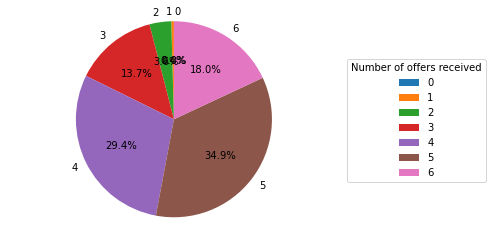

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Customer Distribution by Number of Offers Received

# Filter rows where offer_type is "offer received"
offer_received = merge_df[merge_df['event'] == 'offer received']

# Calculate the count of "offer received" for each person
offer_counts = offer_received['person'].value_counts().sort_index()

# Compute the frequency of counts between 0 to 6
count_frequency = offer_counts.value_counts().reindex(range(0, 7), fill_value=0)

# Plot the pie chart
plt.pie(count_frequency, labels=count_frequency.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Ensures that pie chart is drawn as a circle.

# Display the legend
plt.legend(count_frequency.index, title="Number of offers received", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the pie chart
plt.show()

As can be seen from the figure, the vast majority of users have 3-6 coupons, of which 5 coupons have the most users, accounting for 30%. This shows that the data is of good quality and not biased.

C:\Users\YUQIZH~1\AppData\Local\Temp/ipykernel_13384/1519873797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['age_group'] = pd.cut(transactions['age'], bins=bins, labels=labels, right=False)


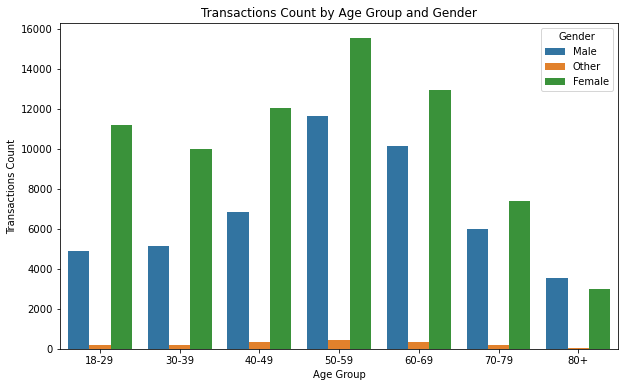

In [53]:
# Analysis of Transactions by Age Group and Gender

# Filter rows where event is "transaction"
transactions = merge_df[merge_df['event'] == 'transaction']

bins = [18, 30, 40, 50, 60, 70, 80, 90] # These are the starting values for the age groups
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
transactions['age_group'] = pd.cut(transactions['age'], bins=bins, labels=labels, right=False)

# Create a plot to show the number of transactions by age group and gender
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='gender', data=transactions)
plt.title('Transactions Count by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Transactions Count')

# Display the legend
# Note here we use custom text labels for the legend
gender_labels = ['Male', 'Other', 'Female']  # Labels for the legend

# Display the legend with custom text labels
plt.legend(title='Gender', labels=gender_labels, loc="best")

# Show the plot
plt.show()

This graph depicts the number of successful transactions by gender and age group. Among them, the 50-60 year old group has the most trading volume. In contrast, the number of transactions by women is relatively large.

C:\Users\YUQIZH~1\AppData\Local\Temp/ipykernel_13384/2884737232.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['age_group'] = pd.cut(transactions['age'], bins=bins, labels=labels, right=False)


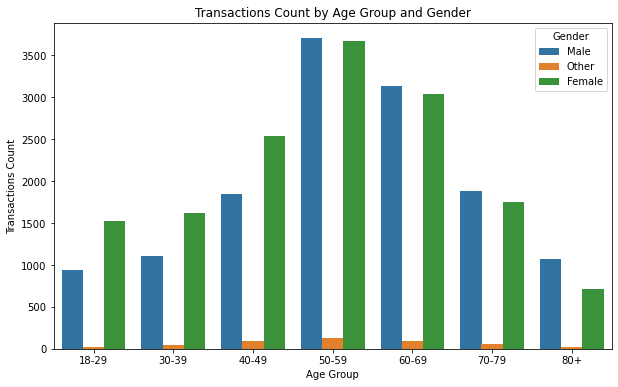

In [54]:
# Analysis of Transactions by Age Group and Gender using coupons

transactions = merge_df[(merge_df['event'] == 'transaction') & (merge_df['offer id'] != 'Null')]

bins = [18, 30, 40, 50, 60, 70, 80, 90] # These are the starting values for the age groups
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
transactions['age_group'] = pd.cut(transactions['age'], bins=bins, labels=labels, right=False)

# Create a plot to show the number of transactions by age group and gender
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='gender', data=transactions)
plt.title('Transactions Count by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Transactions Count')

# Display the legend
# Note here we use custom text labels for the legend
gender_labels = ['Male', 'Other', 'Female']  # Labels for the legend

# Display the legend with custom text labels
plt.legend(title='Gender', labels=gender_labels, loc="best")

# Show the plot
plt.show()

Compared to the figure above, this graph shows the number of purchases made using coupons. You can see that in terms of age, it can also be roughly viewed as a normal distribution. From the perspective of gender, the gap between the amount of male consumption and the amount of female consumption has narrowed, and even the number of male consumption in the 50-60 and 60-70 age groups has exceeded that of women.

# Section 3: Methodology

## Data Preprocessing

In [35]:
# Check for null values
null_values = merge_df.isnull().sum()
print(null_values[null_values > 0])  # This will print columns with null values and their counts

Series([], dtype: int64)


In [36]:
# Transfer string to int/float

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

print("Start processing...")

# 1. Transfer offer_type to the form of one-hot
print("Step 1: One-hot encoding for offer_type...")
encoder = OneHotEncoder(sparse=False)
offer_one_hot = encoder.fit_transform(merge_df[['offer_type']])
offer_one_hot_df = pd.DataFrame(offer_one_hot, columns=encoder.get_feature_names(['offer_type']))

merge_df = pd.concat([merge_df, offer_one_hot_df], axis=1)

# 2. "duration" = "duration" * 24
print("Step 2: Multiplying duration by 24...")
merge_df['duration'] = merge_df['duration'] * 24

# 3. Grouping by person
print("Step 3: Grouping by person...")
grouped = merge_df.groupby('person')


Start processing...
Step 1: One-hot encoding for offer_type...
Step 2: Multiplying duration by 24...
Step 3: Grouping by person...


In [38]:
def information(group):
    dataset = []
    for index, row in group.iterrows():
        array = []
        consumption = 0
        if row["event"] == "offer received" and row["offer_type"] == "informational":
            
            consumption = 0
            for i, r in group.iterrows():

                if r["event"] == "transaction" and int(r["time"]) > int(row["time"]) and int(r["time"]) < int(row["time"]) + int(row["duration"]) and r["offer id"] == "Null":
                    consumption = 1
                if consumption == 1:
                    break
            
            
        if row["event"] == "offer received" and row["offer_type"] != "informational":
            
            consumption = 0
            for i, r in group.iterrows():

                if r["event"] == "transaction" and int(r["time"]) > int(row["time"]) and int(r["time"]) < int(row["time"]) + int(row["duration"]) and r["offer id"] == row["offer id"]:
                    consumption = 1
                if consumption == 1:
                    break
        array.append([
                row['time'],
                row['amount'],
                row['reward_y'],
                row['difficulty'],
                row['web'],
                row['email'],
                row['mobile'],
                row['social'],
                row['gender'],
                row['age'],
                row['income'],
                row['became_member_year'],
                row['became_member_month'],
                row['became_member_day'],
                consumption
                ])     
   

        if row["event"] == "offer received":
            dataset.append(array)
    
    return dataset
                        
print("Step 4: Build the training dataset ...") 

grouped = merge_df.groupby('person')

# Create a progress bar
progress_bar = tqdm(total=len(grouped), desc='Processing groups')

def wrapped_information(group):
    result = information(group)
    progress_bar.update(1)  # 更新进度条
    return result

result_df = grouped.apply(wrapped_information)

progress_bar.close()


Step 4: Build the training dataset ...


Processing groups:   0%|          | 0/17000 [00:00<?, ?it/s]

In [39]:
dataset_final = []
for i in range(17000):
    for j in range(len(result_df[i])):
        dataset_final.append(result_df[i][j][0])
        
for record in dataset_final:
    year, month, day = map(int, record[-4:-1])  # transfer string to int
    record[-4:-1] = [year, month, day]

# Print list of dataset_final
for record in dataset_final:
    print(record)

[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 33, 72000.0, 2017, 4, 21, 1]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 33, 72000.0, 2017, 4, 21, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33, 72000.0, 2017, 4, 21, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33, 72000.0, 2017, 4, 21, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 33, 72000.0, 2017, 4, 21, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 4, 25, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 4, 25, 0]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 40, 57000.0, 2018, 1, 9, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 40, 57000.0, 2018, 1, 9, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 40, 57000.0, 2018, 1, 9, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 40, 57000.0, 2018, 1, 9, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 40, 57000.0, 2018, 1, 9, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 59, 90000.0, 2016, 3, 4, 1]
[168, 0.0, 

[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 59, 93000.0, 2017, 10, 30, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 59, 93000.0, 2017, 10, 30, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 59, 93000.0, 2017, 10, 30, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 59, 93000.0, 2017, 10, 30, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 70, 70000.0, 2016, 7, 1, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 70, 70000.0, 2016, 7, 1, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 70, 70000.0, 2016, 7, 1, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 70, 70000.0, 2016, 7, 1, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 70, 70000.0, 2016, 7, 1, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2015, 8, 9, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2015, 8, 9, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2015, 8, 9, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2

[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 84000.0, 2017, 9, 26, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 84000.0, 2017, 9, 26, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 84000.0, 2017, 9, 26, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 54, 97000.0, 2018, 5, 4, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 54, 97000.0, 2018, 5, 4, 1]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 54, 97000.0, 2018, 5, 4, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 54, 97000.0, 2018, 5, 4, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 54, 97000.0, 2018, 5, 4, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 46, 36000.0, 2016, 6, 11, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 46, 36000.0, 2016, 6, 11, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 46, 36000.0, 2016, 6, 11, 1]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 46, 36000.0, 2016, 6, 11, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 46, 36000.0, 2016, 6, 11, 1]
[0, 0.0, 10.0, 10.0, 0.0,

[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 67, 113000.0, 2018, 7, 4, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 113000.0, 2018, 7, 4, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 113000.0, 2018, 7, 4, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 80, 41000.0, 2014, 1, 19, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 80, 41000.0, 2014, 1, 19, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 80, 41000.0, 2014, 1, 19, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 80, 41000.0, 2014, 1, 19, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 80, 41

[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 81, 81000.0, 2018, 3, 9, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 77, 54000.0, 2017, 12, 15, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 77, 54000.0, 2017, 12, 15, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 77, 54000.0, 2017, 12, 15, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 85, 47000.0, 2018, 7, 2, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 85, 47000.0, 2018, 7, 2, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 85, 47000.0, 2018, 7, 2, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 85, 47000.0, 2018, 7, 2, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 3, 1, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 3, 1, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 3, 1, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 45, 53000.0, 2015, 9, 24, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 45, 53000.0, 2015, 9, 24,

[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 62, 80000.0, 2016, 5, 11, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 60000.0, 2016, 4, 19, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 60000.0, 2016, 4, 19, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 64, 60000.0, 2016, 4, 19, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 64, 60000.0, 2016, 4, 19, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 60000.0, 2016, 4, 19, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 64, 60000.0, 2016, 4, 19, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 42, 98000.0, 2016, 6, 14, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 42, 98000.0, 2016, 6, 14, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 42, 98000.0, 2016, 6, 14, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 42, 98000.0, 2016, 6, 14, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 61, 33000.0, 2017, 11, 12, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 61, 33000.0, 2017, 11, 12, 0]
[336, 0.0, 10.0, 

[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 54, 39000.0, 2017, 10, 29, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 54, 39000.0, 2017, 10, 29, 0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 5, 19, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 5, 19, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 5, 19, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 3, 2, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 3, 2, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 3, 2, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 3, 2, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 3, 2, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 39, 36000.0, 2013, 10, 15, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 39, 36000.0, 2013, 10, 15, 1]
[408, 0.0, 5.0, 5.0, 

[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 67, 57000.0, 2018, 6, 15, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 67, 57000.0, 2018, 6, 15, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 67, 57000.0, 2018, 6, 15, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 92, 94000.0, 2015, 8, 14, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 92, 94000.0, 2015, 8, 14, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 92, 94000.0, 2015, 8, 14, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 92, 94000.0, 2015, 8, 14, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 92, 94000.0, 2015, 8, 14, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 65, 98000.0, 2013, 8, 22, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 65, 98000.0, 2013, 8, 22, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 65, 98000.0, 2013, 8, 22, 0]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 65, 98000.0, 2013, 8, 22, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 65, 98000.0, 2013, 8, 22, 0]
[576, 0.0, 2.0, 10.0, 

[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 41000.0, 2017, 9, 9, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 80, 52000.0, 2017, 12, 4, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 80, 52000.0, 2017, 12, 4, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 80, 52000.0, 2017, 12, 4, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 80, 52000.0, 2017, 12, 4, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 41000.0, 2017, 10, 15, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 58, 41000.0, 2017, 10, 15, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 41000.0, 2017, 10, 15, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 41000.0, 2017, 10, 15, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 58, 41000.0, 2017, 10, 15, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 35, 52000.0, 2018, 2, 27, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 35, 52000.0, 2018, 2, 27, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 35, 52000.0, 2018, 2, 27, 1]
[408, 0.0, 3.0, 

[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 54, 56000.0, 2018, 2, 7, 0]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 54, 56000.0, 2018, 2, 7, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 54, 56000.0, 2018, 2, 7, 0]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 54, 56000.0, 2018, 2, 7, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 66, 60000.0, 2015, 4, 12, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 66, 60000.0, 2015, 4, 12, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 75000.0, 2017, 9, 4, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 75000.0, 2017, 9, 4, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 51, 75000.0, 2017, 9, 4, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 51, 75000.0, 2017, 9, 4, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 78, 66000.0, 2018, 7, 22, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 78, 66000.0, 2018, 7, 22, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 77, 71000.0, 2017, 2, 8, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 

[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 29, 45000.0, 2018, 1, 19, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 29, 45000.0, 2018, 1, 19, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 29, 45000.0, 2018, 1, 19, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 86000.0, 2014, 4, 27, 1]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 86000.0, 2014, 4, 27, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 45, 86000.0, 2014, 4, 27, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 45, 86000.0, 2014, 4, 27, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 89, 71000.0, 2016, 1, 29, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 89, 71000.0, 2016, 1, 29, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 89, 71000.0, 2016, 1, 29, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 89, 71000.0, 2016, 1, 29, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 89, 71000.0, 2016, 1, 29, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 58, 62000.0, 2018, 2, 24, 0]
[336, 0.0, 2.0, 10.0

[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 26, 74000.0, 2018, 1, 7, 0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 23, 53000.0, 2013, 10, 24, 1]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 23, 53000.0, 2013, 10, 24, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 53000.0, 2013, 10, 24, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 23, 53000.0, 2013, 10, 24, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 53000.0, 2013, 10, 24, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 43000.0, 2018, 2, 13, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 43000.0, 2018, 2, 13, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 43000.0, 2018, 2, 13, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 23, 43000.0, 2018, 2, 13, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 43000.0, 2018, 2, 13, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 53, 73000.0, 2017, 2, 20, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 53, 73000.0, 2017, 2, 20, 1]
[336, 0.0, 2.0

[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2016, 4, 10, 1]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 4, 10, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2016, 4, 10, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 4, 10, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 67, 103000.0, 2017, 1, 22, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 103000.0, 2017, 1, 22, 1]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 103000.0, 2017, 1, 22, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 67, 103000.0, 2017, 1, 22, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 67, 103000.0, 2017, 1, 22, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 67, 103000.0, 2017, 1, 22, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 53, 94000.0, 2017, 9, 15, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 53, 94000.0, 2017, 9, 15, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 56,

[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 45, 82000.0, 2017, 4, 24, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 82000.0, 2017, 4, 24, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 29, 59000.0, 2018, 5, 29, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2018, 5, 29, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2018, 5, 29, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2018, 5, 29, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 58, 63000.0, 2016, 3, 31, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 63000.0, 2016, 3, 31, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 63000.0, 2016, 3, 31, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 58, 63000.0, 2016, 3, 31, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 19, 63000.0, 2018, 4, 29, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 19, 63000.0, 2018, 4, 29, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 19, 63000.0, 2018, 4, 29, 0]
[504, 0.0, 3.0, 

[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 62, 70000.0, 2016, 12, 12, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 62, 70000.0, 2016, 12, 12, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 55000.0, 2016, 11, 24, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 56, 55000.0, 2016, 11, 24, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 56, 55000.0, 2016, 11, 24, 1]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 56, 55000.0, 2016, 11, 24, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 55000.0, 2016, 11, 24, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 55000.0, 2016, 11, 24, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 53, 87000.0, 2015, 12, 21, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 87000.0, 2015, 12, 21, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 87000.0, 2015, 12, 21, 1]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 53, 87000.0, 2015, 12, 21, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 87000.0, 2015, 12, 21, 1]
[168, 

[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 71, 63000.0, 2018, 2, 11, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 99000.0, 2018, 1, 16, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 60, 99000.0, 2018, 1, 16, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 99000.0, 2018, 1, 16, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 60, 99000.0, 2018, 1, 16, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 99000.0, 2018, 1, 16, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 56000.0, 2017, 12, 8, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 56000.0, 2017, 12, 8, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 56000.0, 2017, 12, 8, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 56000.0, 2017, 12, 8, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 42, 65000.0, 2018, 1, 19, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 42, 65000.0, 2018, 1, 19, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 42, 65000.0, 2018, 1, 19, 1]
[576, 0.0, 5.0, 5.

[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 57, 97000.0, 2017, 12, 21, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 57, 97000.0, 2017, 12, 21, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 5, 8, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 5, 8, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 5, 8, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 5, 8, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 5, 8, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 47, 54000.0, 2017, 11, 27, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 47, 54000.0, 2017, 11, 27, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 47, 54000.0, 2017, 11, 27, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 85, 90000.0, 2017, 10, 31, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 85, 90000.0, 2017, 10, 31, 1]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0,

[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 7, 27, 0]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 39, 55000.0, 2018, 4, 21, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 39, 55000.0, 2018, 4, 21, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 39, 55000.0, 2018, 4, 21, 0]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39, 55000.0, 2018, 4, 21, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 39, 55000.0, 2018, 4, 21, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 36, 70000.0, 2017, 6, 25, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 36, 70000.0, 2017, 6, 25, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 36, 70000.0, 2017, 6, 25, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 36, 70000.0, 2017, 6, 25, 1]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 36, 70000.0, 2017, 6, 25, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 113000.0, 2017, 9, 23, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 113000.0, 2017, 9, 23, 1]
[336, 0.0

[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34, 68000.0, 2017, 12, 14, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 34, 68000.0, 2017, 12, 14, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 62, 56000.0, 2016, 4, 10, 1]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 62, 56000.0, 2016, 4, 10, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 62, 56000.0, 2016, 4, 10, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 62, 56000.0, 2016, 4, 10, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 73, 43000.0, 2017, 9, 8, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 73, 43000.0, 2017, 9, 8, 0]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 73, 43000.0, 2017, 9, 8, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 73, 43000.0, 2017, 9, 8, 0]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 73, 43000.0, 2017, 9, 8, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 84, 81000.0, 2017, 9, 7, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 84, 81000.0, 2017, 9, 7, 0]
[0, 0.0, 2.0, 10.0, 1

[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 50000.0, 2016, 5, 19, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 61, 50000.0, 2016, 5, 19, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 61, 50000.0, 2016, 5, 19, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 4, 22, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 4, 22, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 4, 22, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 4, 22, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 4, 22, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 4, 22, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40, 50000.0, 2017, 3, 3, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 40, 50000.0, 2017, 3, 3, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40, 50000.0, 2017, 3, 3, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.

[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 76, 66000.0, 2016, 10, 27, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 76, 66000.0, 2016, 10, 27, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 76, 66000.0, 2016, 10, 27, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 76, 66000.0, 2016, 10, 27, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 39, 73000.0, 2018, 3, 24, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 39, 73000.0, 2018, 3, 24, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 39, 73000.0, 2018, 3, 24, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 73, 32000.0, 2016, 6, 17, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 73, 32000.0, 2016, 6, 17, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 73, 32000.0, 2016, 6, 17, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 73, 32000.0, 2016, 6, 17, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 73, 32000.0, 2016, 6, 17, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 73, 32000.0, 2016, 6, 17, 1]
[0, 0.0, 3.0, 7.0

[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 28, 72000.0, 2017, 3, 31, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28, 72000.0, 2017, 3, 31, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28, 72000.0, 2017, 3, 31, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36, 38000.0, 2018, 2, 4, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36, 38000.0, 2018, 2, 4, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 36, 38000.0, 2018, 2, 4, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 36, 38000.0, 2018, 2, 4, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36, 38000.0, 2018, 2, 4, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 36, 38000.0, 2018, 2, 4, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 86, 59000.0, 2015, 1, 23, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 86, 59000.0, 2015, 1, 23, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 86, 59000.0, 2015, 1, 23, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 86, 59000.0, 2015, 1, 23, 1]
[576, 0.0, 5.0, 5.0, 1.

[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 59, 98000.0, 2017, 9, 12, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 57, 32000.0, 2018, 1, 24, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 57, 32000.0, 2018, 1, 24, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 57, 32000.0, 2018, 1, 24, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 57, 32000.0, 2018, 1, 24, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 73000.0, 2014, 4, 28, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 73000.0, 2014, 4, 28, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 73000.0, 2014, 4, 28, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 73000.0, 2014, 4, 28, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 58, 73000.0, 2014, 4, 28, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 58, 73000.0, 2014, 4, 28, 0]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 32, 43000.0, 2014, 9, 4, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 32, 43000.0, 2014, 9, 4, 0]
[336, 0.0, 10.0, 10.

[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31, 54000.0, 2017, 9, 23, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31, 54000.0, 2017, 9, 23, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 31, 54000.0, 2017, 9, 23, 1]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31, 54000.0, 2017, 9, 23, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 71, 58000.0, 2017, 1, 31, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 71, 58000.0, 2017, 1, 31, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 71, 58000.0, 2017, 1, 31, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 71, 58000.0, 2017, 1, 31, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 53, 38000.0, 2017, 9, 24, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 53, 38000.0, 2017, 9, 24, 1]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 53, 38000.0, 2017, 9, 24, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 53, 38000.0, 2017, 9, 24, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 38000.0, 2017, 9, 24, 1]
[0, 0.0, 2.0, 10.0, 

[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 34, 66000.0, 2017, 11, 29, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 34, 66000.0, 2017, 11, 29, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 63000.0, 2017, 8, 10, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 58, 63000.0, 2017, 8, 10, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 63000.0, 2017, 8, 10, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 58, 63000.0, 2017, 8, 10, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 58, 63000.0, 2017, 8, 10, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 9, 1, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 9, 1, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 9, 1, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 9, 1, 0]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 9, 1, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1

[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 46, 71000.0, 2018, 4, 21, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 24, 53000.0, 2018, 2, 12, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 24, 53000.0, 2018, 2, 12, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 24, 53000.0, 2018, 2, 12, 0]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 24, 53000.0, 2018, 2, 12, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 24, 53000.0, 2018, 2, 12, 0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 55, 119000.0, 2016, 3, 14, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 55, 119000.0, 2016, 3, 14, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 55, 119000.0, 2016, 3, 14, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 55, 119000.0, 2016, 3, 14, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 35, 60000.0, 2017, 8, 30, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 35, 60000.0, 2017, 8, 30, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 35, 60000.0, 2017, 8, 30, 1]
[408, 0.0, 0.0, 0.0

[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 49, 61000.0, 2018, 3, 31, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 7, 30, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 7, 30, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 7, 30, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 58000.0, 2018, 2, 19, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 56, 58000.0, 2018, 2, 19, 1]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 56, 58000.0, 2018, 2, 19, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 56, 58000.0, 2018, 2, 19, 0]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 58000.0, 2018, 2, 19, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 58000.0, 2018, 2, 19, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 30, 40000.0, 2017, 12, 3, 1]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 30, 40000.0, 2017, 12, 3, 1]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 30, 40000.0, 2017, 

[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 30, 73000.0, 2018, 5, 1, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 54000.0, 2018, 2, 7, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 54000.0, 2018, 2, 7, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 54000.0, 2018, 2, 7, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 54000.0, 2018, 2, 7, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 37, 31000.0, 2016, 1, 30, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37, 31000.0, 2016, 1, 30, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 37, 31000.0, 2016, 1, 30, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37, 31000.0, 2016, 1, 30, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 37, 31000.0, 2016, 1, 30, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 81000.0, 2017, 2, 17, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 81000.0, 2017, 2, 17, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 81000.0, 2017, 2, 17, 1]
[408, 0.0, 0.0, 0.0, 1.0,

[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 56, 61000.0, 2017, 7, 22, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 49, 68000.0, 2017, 6, 19, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49, 68000.0, 2017, 6, 19, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 1, 30, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 1, 30, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 1, 30, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 54000.0, 2018, 5, 9, 1]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 54000.0, 2018, 5, 9, 0]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 54000.0, 2018, 5, 9, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 54000.0, 2018, 5, 9, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 50, 108000.0, 2016, 5, 29, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 50, 108000.0, 2016, 5, 29, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 50, 108000.0, 2016, 5

[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 10, 13, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 10, 13, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2016, 10, 13, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 41, 38000.0, 2017, 9, 16, 0]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 41, 38000.0, 2017, 9, 16, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 41, 38000.0, 2017, 9, 16, 0]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 66, 83000.0, 2018, 6, 7, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 66, 83000.0, 2018, 6, 7, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 47, 48000.0, 2018, 6, 2, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 47, 48000.0, 2018, 6, 2, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 47, 48000.0, 2018, 6, 2, 0]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 47, 48000.0, 2018, 6, 2, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 47, 48000.0, 2018, 6,

[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 59, 73000.0, 2015, 7, 23, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 65, 47000.0, 2017, 9, 16, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 65, 47000.0, 2017, 9, 16, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 65, 47000.0, 2017, 9, 16, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 71, 33000.0, 2018, 1, 7, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 71, 33000.0, 2018, 1, 7, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 71, 33000.0, 2018, 1, 7, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 71, 33000.0, 2018, 1, 7, 0]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 68, 104000.0, 2016, 10, 16, 0]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 68, 104000.0, 2016, 10, 16, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 68, 104000.0, 2016, 10, 16, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 68, 104000.0, 2016, 10, 16, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 48, 96000.0, 2016, 9, 8, 1]
[168, 0.0, 10.0, 1

[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 53, 110000.0, 2016, 11, 30, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 53, 110000.0, 2016, 11, 30, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 53, 110000.0, 2016, 11, 30, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 67000.0, 2018, 6, 29, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 67000.0, 2018, 6, 29, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 67000.0, 2018, 6, 29, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 67000.0, 2018, 6, 29, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 67000.0, 2018, 6, 29, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 67000.0, 2018, 6, 29, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 55, 71000.0, 2017, 8, 15, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 55, 71000.0, 2017, 8, 15, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 55, 71000.0, 2017, 8, 15, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 55, 71000.0, 2017, 8, 15, 1]
[576, 0.0, 2.0, 10

[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 58, 54000.0, 2018, 6, 1, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 53, 53000.0, 2017, 8, 2, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 53000.0, 2017, 8, 2, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 53000.0, 2017, 8, 2, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 53, 53000.0, 2017, 8, 2, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 53000.0, 2017, 8, 2, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 1, 12, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 1, 12, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 1, 12, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 1, 12, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 75, 84000.0, 2016, 3, 15, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 75, 84000.0, 2016, 3, 15, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 75, 84000.0, 2

[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 9, 29, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 9, 29, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 5, 25, 1]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 5, 25, 0]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 5, 25, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 5, 25, 0]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 55, 73000.0, 2016, 12, 21, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 55, 73000.0, 2016, 12, 21, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 55, 73000.0, 2016, 12, 21, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 55, 73000.0, 2016, 12, 21, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 55, 73000.0, 2016, 12, 21, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 68, 79000.0, 2017, 5, 24, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0,

[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2015, 11, 23, 0]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2013, 9, 24, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2013, 9, 24, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2013, 9, 24, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2013, 9, 24, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 78, 85000.0, 2016, 3, 12, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 78, 85000.0, 2016, 3, 12, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 78, 85000.0, 2016, 3, 12, 1]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 78, 85000.0, 2016, 3, 12, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 78, 85000.0, 2016, 3, 12, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 78, 85000.0, 2016, 3, 12, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 41, 94000.0, 2016, 4, 24, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0,

[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 5, 0]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 5, 1]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 5, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 54, 53000.0, 2016, 12, 25, 1]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 54, 53000.0, 2016, 12, 25, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 54, 53000.0, 2016, 12, 25, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 54, 53000.0, 2016, 12, 25, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 54, 53000.0, 2016, 12, 25, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 54, 53000.0, 2016, 12, 25, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 70, 45000.0, 2017, 7, 13, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 70, 45000.0, 2017, 7, 13, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 70, 45000.0, 2017, 7, 13, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 70, 45

[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 50000.0, 2017, 9, 16, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 23, 50000.0, 2017, 9, 16, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 23, 50000.0, 2017, 9, 16, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 23, 50000.0, 2017, 9, 16, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 23, 50000.0, 2017, 9, 16, 0]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 60, 77000.0, 2016, 9, 24, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 60, 77000.0, 2016, 9, 24, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 77000.0, 2016, 9, 24, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 60, 77000.0, 2016, 9, 24, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 60, 77000.0, 2016, 9, 24, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 77000.0, 2016, 9, 24, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 11, 26, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2017, 11, 26, 0]
[

[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 53, 100000.0, 2016, 8, 25, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 45, 92000.0, 2018, 1, 16, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 92000.0, 2018, 1, 16, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 92000.0, 2018, 1, 16, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 32, 53000.0, 2015, 11, 19, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 32, 53000.0, 2015, 11, 19, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 32, 53000.0, 2015, 11, 19, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 32, 53000.0, 2015, 11, 19, 0]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 32, 53000.0, 2015, 11, 19, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 32, 53000.0, 2015, 11, 19, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 54, 48000.0, 2016, 6, 12, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 54, 48000.0, 2016, 6, 12, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 54, 48000.0, 2016, 6, 12, 1]
[408, 0.0, 5.0, 

[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 66, 73000.0, 2017, 11, 21, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 29, 40000.0, 2018, 4, 17, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 29, 40000.0, 2018, 4, 17, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 69, 54000.0, 2017, 5, 16, 0]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 69, 54000.0, 2017, 5, 16, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 69, 54000.0, 2017, 5, 16, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 69, 54000.0, 2017, 5, 16, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 68, 59000.0, 2017, 12, 22, 1]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 68, 59000.0, 2017, 12, 22, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 68, 59000.0, 2017, 12, 22, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 68, 59000.0, 2017, 12, 22, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 62, 99000.0, 2018, 5, 5, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 99000.0, 2018, 5, 5, 1]
[336, 0.0, 5.0, 

[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 63, 116000.0, 2016, 3, 24, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 63, 116000.0, 2016, 3, 24, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 63, 116000.0, 2016, 3, 24, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 22, 35000.0, 2017, 1, 22, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 22, 35000.0, 2017, 1, 22, 0]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 22, 35000.0, 2017, 1, 22, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 22, 35000.0, 2017, 1, 22, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 22, 35000.0, 2017, 1, 22, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 61, 72000.0, 2018, 1, 22, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 61, 72000.0, 2018, 1, 22, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 61, 72000.0, 2018, 1, 22, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 67, 85000.0, 2017, 8, 22, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 67, 85000.0, 2017, 8, 22, 0]
[336, 0.0, 2.0, 

[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 27, 33000.0, 2014, 1, 26, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 64, 61000.0, 2017, 7, 31, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 64, 61000.0, 2017, 7, 31, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 64, 61000.0, 2017, 7, 31, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 64, 61000.0, 2017, 7, 31, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 64, 61000.0, 2017, 7, 31, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 47, 31000.0, 2018, 1, 26, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 47, 31000.0, 2018, 1, 26, 1]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 47, 31000.0, 2018, 1, 26, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 47, 31000.0, 2018, 1, 26, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 79, 74000.0, 2018, 1, 23, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 79, 74000.0, 2018, 1, 23, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 79, 74000.0, 2018, 1, 23, 0]
[408, 0.0, 5.0, 5.0, 1.

[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 28, 44000.0, 2017, 10, 20, 1]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28, 44000.0, 2017, 10, 20, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40, 48000.0, 2018, 1, 22, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 40, 48000.0, 2018, 1, 22, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40, 48000.0, 2018, 1, 22, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 40, 48000.0, 2018, 1, 22, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 40, 48000.0, 2018, 1, 22, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40, 48000.0, 2018, 1, 22, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 100, 63000.0, 2015, 10, 13, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100, 63000.0, 2015, 10, 13, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100, 63000.0, 2015, 10, 13, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 64, 110000.0, 2016, 4, 23, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 110000.0, 2016, 4, 23, 0]
[408, 0.

[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 73, 55000.0, 2015, 9, 12, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 73, 55000.0, 2015, 9, 12, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 73, 55000.0, 2015, 9, 12, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 73, 55000.0, 2015, 9, 12, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 73, 55000.0, 2015, 9, 12, 1]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 60, 99000.0, 2017, 8, 5, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 60, 99000.0, 2017, 8, 5, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 99000.0, 2017, 8, 5, 1]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 99000.0, 2017, 8, 5, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 99000.0, 2017, 8, 5, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 99000.0, 2017, 8, 5, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49, 38000.0, 2018, 7, 5, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49, 38000.0, 2018, 7, 5, 0]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0

[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 13, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 13, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 78, 115000.0, 2016, 8, 1, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 78, 115000.0, 2016, 8, 1, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 78, 115000.0, 2016, 8, 1, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 78, 115000.0, 2016, 8, 1, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 78, 115000.0, 2016, 8, 1, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 6, 21, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 6, 21, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 6, 21, 0]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 6, 21, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 6, 21, 0]
[0, 0.0, 10.0, 10.0

[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 95, 72000.0, 2017, 4, 21, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 42, 58000.0, 2016, 12, 25, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 42, 58000.0, 2016, 12, 25, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 42, 58000.0, 2016, 12, 25, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 42, 58000.0, 2016, 12, 25, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 42, 58000.0, 2016, 12, 25, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 42, 58000.0, 2016, 12, 25, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38, 69000.0, 2018, 3, 10, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 38, 69000.0, 2018, 3, 10, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 38, 69000.0, 2018, 3, 10, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38, 69000.0, 2018, 3, 10, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 38, 69000.0, 2018, 3, 10, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 54, 84000.0, 2017, 10, 7, 0]
[336, 0.0

[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 65, 92000.0, 2015, 6, 23, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 78, 79000.0, 2018, 3, 30, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 78, 79000.0, 2018, 3, 30, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 78, 79000.0, 2018, 3, 30, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 78, 79000.0, 2018, 3, 30, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 61, 40000.0, 2018, 5, 1, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 61, 40000.0, 2018, 5, 1, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 61, 40000.0, 2018, 5, 1, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 109000.0, 2016, 4, 27, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 109000.0, 2016, 4, 27, 1]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 60, 109000.0, 2016, 4, 27, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 60, 109000.0, 2016, 4, 27, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 60, 109000.0, 2016, 4, 27, 1]
[0, 0.0, 5.0, 5.0, 1

[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 60, 69000.0, 2017, 2, 1, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 60, 69000.0, 2017, 2, 1, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 60, 69000.0, 2017, 2, 1, 1]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 60, 69000.0, 2017, 2, 1, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 60, 69000.0, 2017, 2, 1, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 52000.0, 2016, 6, 25, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 52000.0, 2016, 6, 25, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 52000.0, 2016, 6, 25, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 31000.0, 2017, 9, 2, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 43, 31000.0, 2017, 9, 2, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 31000.0, 2017, 9, 2, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 31000.0, 2017, 9, 2, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 31000.0, 2017, 9, 2, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.

[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 59, 52000.0, 2013, 11, 24, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 59, 52000.0, 2013, 11, 24, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 72, 74000.0, 2018, 3, 18, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 72, 74000.0, 2018, 3, 18, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 72, 74000.0, 2018, 3, 18, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 72, 74000.0, 2018, 3, 18, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 72, 74000.0, 2018, 3, 18, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 29, 33000.0, 2016, 6, 19, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 29, 33000.0, 2016, 6, 19, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 29, 33000.0, 2016, 6, 19, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 29, 33000.0, 2016, 6, 19, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 29, 33000.0, 2016, 6, 19, 0]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 76000.0, 2018, 1, 2, 0]
[336, 0.0, 5.

[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 52000.0, 2018, 5, 5, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 52000.0, 2018, 5, 5, 1]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 45, 52000.0, 2018, 5, 5, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 45, 52000.0, 2018, 5, 5, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 52000.0, 2018, 5, 5, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 72, 91000.0, 2017, 2, 1, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 72, 91000.0, 2017, 2, 1, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 72, 91000.0, 2017, 2, 1, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 72, 91000.0, 2017, 2, 1, 0]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 72, 91000.0, 2017, 2, 1, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 72, 91000.0, 2017, 2, 1, 1]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 71, 75000.0, 2017, 6, 24, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 71, 75000.0, 2017, 6, 24, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0,

[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 47000.0, 2017, 12, 29, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 47000.0, 2017, 12, 29, 1]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 47000.0, 2017, 12, 29, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 41, 43000.0, 2017, 1, 7, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 41, 43000.0, 2017, 1, 7, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 41, 43000.0, 2017, 1, 7, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 41, 43000.0, 2017, 1, 7, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 41, 43000.0, 2017, 1, 7, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 41, 43000.0, 2017, 1, 7, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 57, 85000.0, 2017, 12, 14, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 57, 85000.0, 2017, 12, 14, 1]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 57, 85000.0, 2017, 12, 14, 0]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 57, 85000.0, 2017, 12, 14, 1]
[576, 0.0, 10.0, 10.

[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 64, 56000.0, 2017, 12, 7, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 64, 56000.0, 2017, 12, 7, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 56000.0, 2017, 12, 7, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 56000.0, 2017, 12, 7, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 64, 56000.0, 2017, 12, 7, 0]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 64, 56000.0, 2017, 12, 7, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 21, 36000.0, 2017, 9, 23, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 21, 36000.0, 2017, 9, 23, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 21, 36000.0, 2017, 9, 23, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 21, 36000.0, 2017, 9, 23, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 30, 0]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 1, 30, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.5, 118, 65404.9915682968, 20

[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 40, 65000.0, 2015, 11, 11, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 40, 65000.0, 2015, 11, 11, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 75, 65000.0, 2018, 4, 23, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 75, 65000.0, 2018, 4, 23, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 75, 65000.0, 2018, 4, 23, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 75, 65000.0, 2018, 4, 23, 0]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 75, 65000.0, 2018, 4, 23, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 43000.0, 2017, 1, 31, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 43000.0, 2017, 1, 31, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 62, 43000.0, 2017, 1, 31, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 43000.0, 2017, 1, 31, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 43000.0, 2017, 1, 31, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 62, 43000.0, 2016, 8, 7, 1]
[336, 0.0, 2.0, 10.0, 1

[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 49, 36000.0, 2018, 5, 15, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49, 36000.0, 2018, 5, 15, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 44, 35000.0, 2018, 1, 24, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 44, 35000.0, 2018, 1, 24, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 44, 35000.0, 2018, 1, 24, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 40000.0, 2017, 11, 25, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 58, 40000.0, 2017, 11, 25, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 58, 40000.0, 2017, 11, 25, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 40000.0, 2017, 11, 25, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 51000.0, 2018, 3, 24, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 43, 51000.0, 2018, 3, 24, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 51000.0, 2018, 3, 24, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 43, 51000.0, 2018, 3, 24, 0]
[504, 0.0, 3.0, 7

[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 55, 93000.0, 2017, 7, 28, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 34, 64000.0, 2017, 2, 28, 1]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 34, 64000.0, 2017, 2, 28, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 34, 64000.0, 2017, 2, 28, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 34, 64000.0, 2017, 2, 28, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 34, 64000.0, 2017, 2, 28, 0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 58, 89000.0, 2017, 7, 29, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 89000.0, 2017, 7, 29, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 89000.0, 2017, 7, 29, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 89000.0, 2017, 7, 29, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 58, 89000.0, 2017, 7, 29, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 58, 89000.0, 2017, 7, 29, 1]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2016, 3, 7, 0]
[336, 0

[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 55, 53000.0, 2014, 4, 11, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 55, 53000.0, 2014, 4, 11, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 78, 104000.0, 2018, 1, 29, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 78, 104000.0, 2018, 1, 29, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 78, 104000.0, 2018, 1, 29, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 78, 104000.0, 2018, 1, 29, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 78, 104000.0, 2018, 1, 29, 0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 2, 6, 0]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 52, 68000.0, 2017, 8, 18, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 68000.0, 

[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32, 41000.0, 2018, 2, 17, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 32, 41000.0, 2018, 2, 17, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32, 41000.0, 2018, 2, 17, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 89, 88000.0, 2018, 3, 8, 0]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 89, 88000.0, 2018, 3, 8, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 89, 88000.0, 2018, 3, 8, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 89, 88000.0, 2018, 3, 8, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 89, 88000.0, 2018, 3, 8, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 89, 88000.0, 2018, 3, 8, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 48, 60000.0, 2017, 9, 11, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 48, 60000.0, 2017, 9, 11, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 48, 60000.0, 2017, 9, 11, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 48, 60000.0, 2017, 9, 11, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1

[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 77, 58000.0, 2017, 8, 7, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 69, 116000.0, 2017, 8, 3, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 69, 116000.0, 2017, 8, 3, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 69, 116000.0, 2017, 8, 3, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 69, 116000.0, 2017, 8, 3, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 69, 116000.0, 2017, 8, 3, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 53, 54000.0, 2018, 6, 7, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 53, 54000.0, 2018, 6, 7, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 53, 54000.0, 2018, 6, 7, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 53, 54000.0, 2018, 6, 7, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 53, 54000.0, 2018, 6, 7, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 55, 55000.0, 2017, 8, 20, 1]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 55, 55000.0, 2017, 8, 20, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0

[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2015, 8, 23, 0]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2015, 8, 23, 0]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2015, 8, 23, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2015, 8, 23, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2015, 8, 23, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 1, 18, 0]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 1, 18, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 1, 18, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 64, 86000.0, 2016, 3, 26, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 64, 86000.0, 2016, 3, 26, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 64, 86000.0, 2016, 3, 26, 1]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 64, 86000.0, 2016, 3, 26, 1]
[504, 0.0, 3.0,

[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 23, 60000.0, 2015, 12, 14, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 60000.0, 2015, 12, 14, 0]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 60000.0, 2015, 12, 14, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 35, 65000.0, 2017, 11, 5, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 35, 65000.0, 2017, 11, 5, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 35, 65000.0, 2017, 11, 5, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 35, 65000.0, 2017, 11, 5, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 35, 65000.0, 2017, 11, 5, 1]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 35, 65000.0, 2017, 11, 5, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 82, 73000.0, 2017, 7, 6, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 82, 73000.0, 2017, 7, 6, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 82, 73000.0, 2017, 7, 6, 0]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 82, 73000.0, 2017, 7, 6, 1]
[504, 0.0, 10.0, 10.0, 

[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 83000.0, 2016, 12, 24, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 83000.0, 2016, 12, 24, 0]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 83000.0, 2016, 12, 24, 0]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 83000.0, 2016, 12, 24, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 83000.0, 2016, 12, 24, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33, 39000.0, 2018, 3, 10, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 33, 39000.0, 2018, 3, 10, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33, 39000.0, 2018, 3, 10, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 33, 39000.0, 2018, 3, 10, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 70, 99000.0, 2016, 6, 30, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 70, 99000.0, 2016, 6, 30, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 70, 99000.0, 2016, 6, 30, 0]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 70, 99000.0, 2016, 6, 30, 1]
[576, 0.0, 0.0, 0.0, 

[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 10, 14, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 10, 14, 0]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 10, 14, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 81, 92000.0, 2016, 9, 27, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 81, 92000.0, 2016, 9, 27, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 81, 92000.0, 2016, 9, 27, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 81, 92000.0, 2016, 9, 27, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34, 65000.0, 2018, 4, 3, 0]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34, 65000.0, 2018, 4, 3, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34, 65000.0, 2018, 4, 3, 0]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 34, 65000.0, 2018, 4, 3, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 32, 42000.0, 2018, 6, 28, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 32, 42000.0, 

[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 8, 25, 0]
[576, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2017, 8, 25, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 44, 86000.0, 2017, 10, 31, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 44, 86000.0, 2017, 10, 31, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 44, 86000.0, 2017, 10, 31, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 44, 86000.0, 2017, 10, 31, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 44, 86000.0, 2017, 10, 31, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 58, 97000.0, 2017, 5, 10, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 97000.0, 2017, 5, 10, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 97000.0, 2017, 5, 10, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 58, 97000.0, 2017, 5, 10, 1]
[504, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 97000.0, 2017, 5, 10, 0]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 58, 97000.0, 2017, 

[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 86, 95000.0, 2017, 3, 23, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 86, 95000.0, 2017, 3, 23, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 73, 90000.0, 2015, 12, 1, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 73, 90000.0, 2015, 12, 1, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 73, 90000.0, 2015, 12, 1, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 73, 90000.0, 2015, 12, 1, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 73, 90000.0, 2015, 12, 1, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2013, 9, 16, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 29, 59000.0, 2013, 9, 16, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2013, 9, 16, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2013, 9, 16, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 29, 59000.0, 2013, 9, 16, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 29, 59000.0, 2013, 9, 16, 1]
[0, 0.0, 3.0, 7.0

[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 25, 53000.0, 2014, 7, 17, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 25, 53000.0, 2014, 7, 17, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 25, 53000.0, 2014, 7, 17, 1]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 25, 53000.0, 2014, 7, 17, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 83, 66000.0, 2016, 6, 8, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 83, 66000.0, 2016, 6, 8, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 83, 66000.0, 2016, 6, 8, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 83, 66000.0, 2016, 6, 8, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 83, 66000.0, 2016, 6, 8, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 35000.0, 2018, 6, 17, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 62, 35000.0, 2018, 6, 17, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 62, 35000.0, 2018, 6, 17, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 62, 35000.0, 2018, 6, 17, 1]
[576, 0.0, 2.0, 10.0, 1.

[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 53000.0, 2014, 5, 25, 0]
[576, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53, 53000.0, 2014, 5, 25, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36, 70000.0, 2014, 12, 7, 0]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36, 70000.0, 2014, 12, 7, 0]
[336, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 36, 70000.0, 2014, 12, 7, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36, 70000.0, 2014, 12, 7, 0]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 36, 70000.0, 2014, 12, 7, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 36, 70000.0, 2014, 12, 7, 0]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 49, 80000.0, 2017, 11, 5, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.0, 49, 80000.0, 2017, 11, 5, 1]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 49, 80000.0, 2017, 11, 5, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 48, 97000.0, 2015, 9, 30, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 48, 97000.0, 2015, 9, 30, 1]
[576, 0.0, 5.0, 5.0, 1

[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 74, 98000.0, 2016, 5, 22, 0]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 74, 98000.0, 2016, 5, 22, 1]
[504, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 0.0, 74, 98000.0, 2016, 5, 22, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 74, 98000.0, 2016, 5, 22, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 53000.0, 2017, 8, 10, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 51, 53000.0, 2017, 8, 10, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 53000.0, 2017, 8, 10, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 51, 53000.0, 2017, 8, 10, 0]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51, 53000.0, 2017, 8, 10, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 51, 53000.0, 2017, 8, 10, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 93, 115000.0, 2017, 2, 20, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 93, 115000.0, 2017, 2, 20, 1]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 93, 115000.0, 2017, 2, 20, 0]
[504, 0.0, 3.0, 7

[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 24, 70000.0, 2018, 7, 7, 1]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 45, 72000.0, 2017, 3, 9, 1]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 45, 72000.0, 2017, 3, 9, 0]
[408, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 45, 72000.0, 2017, 3, 9, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 45, 72000.0, 2017, 3, 9, 1]
[576, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 45, 72000.0, 2017, 3, 9, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 58, 52000.0, 2016, 10, 2, 1]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 58, 52000.0, 2016, 10, 2, 1]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 58, 52000.0, 2016, 10, 2, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50, 90000.0, 2017, 4, 15, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50, 90000.0, 2017, 4, 15, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 50, 90000.0, 2017, 4, 15, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 28, 52000.0, 2018, 7, 14, 1]
[336, 0.0, 10.0, 10.0, 0.

[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 67, 110000.0, 2015, 7, 29, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 110000.0, 2015, 7, 29, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 67, 110000.0, 2015, 7, 29, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 110000.0, 2015, 7, 29, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 67, 110000.0, 2015, 7, 29, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 67, 110000.0, 2015, 7, 29, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 78, 82000.0, 2015, 12, 2, 1]
[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 78, 82000.0, 2015, 12, 2, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 78, 82000.0, 2015, 12, 2, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 78, 82000.0, 2015, 12, 2, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 65, 60000.0, 2018, 5, 2, 1]
[168, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 65, 60000.0, 2018, 5, 2, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 65, 60000.0, 2018, 5, 2, 1]
[504, 0.0, 0.0, 0.

[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 27, 34000.0, 2017, 11, 19, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 27, 34000.0, 2017, 11, 19, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 27, 34000.0, 2017, 11, 19, 1]
[576, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 27, 34000.0, 2017, 11, 19, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 62000.0, 2015, 9, 9, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 45, 62000.0, 2015, 9, 9, 1]
[0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 61, 114000.0, 2017, 11, 23, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 61, 114000.0, 2017, 11, 23, 1]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 61, 114000.0, 2017, 11, 23, 1]
[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 61, 114000.0, 2017, 11, 23, 0]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 21, 46000.0, 2015, 1, 7, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 21, 46000.0, 2015, 1, 7, 0]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 21, 46000.0, 2015, 1, 7, 1]
[0, 0.0, 2.0, 10.

[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 54, 77000.0, 2018, 1, 19, 1]
[0, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 62, 41000.0, 2018, 3, 23, 0]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 62, 41000.0, 2018, 3, 23, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 62, 41000.0, 2018, 3, 23, 1]
[504, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 62, 41000.0, 2018, 3, 23, 0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 45, 73000.0, 2018, 6, 7, 0]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 45, 73000.0, 2018, 6, 7, 0]
[408, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 45, 73000.0, 2018, 6, 7, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 45, 73000.0, 2018, 6, 7, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 45, 73000.0, 2018, 6, 7, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60, 50000.0, 2016, 7, 4, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 60, 50000.0, 2016, 7, 4, 1]
[336, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 60, 50000.0, 2016, 7, 4, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0,

[576, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 44, 55000.0, 2015, 6, 14, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28, 68000.0, 2018, 7, 9, 1]
[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 28, 68000.0, 2018, 7, 9, 0]
[408, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 28, 68000.0, 2018, 7, 9, 1]
[504, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 28, 68000.0, 2018, 7, 9, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28, 68000.0, 2018, 7, 9, 1]
[0, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 68, 97000.0, 2015, 1, 4, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 68, 97000.0, 2015, 1, 4, 0]
[336, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 68, 97000.0, 2015, 1, 4, 1]
[408, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 68, 97000.0, 2015, 1, 4, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 68, 97000.0, 2015, 1, 4, 1]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 68, 97000.0, 2015, 1, 4, 1]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32, 68000.0, 2018, 6, 2, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1

[168, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 61, 63000.0, 2017, 4, 11, 1]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 63000.0, 2017, 4, 11, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 61, 63000.0, 2017, 4, 11, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 61, 63000.0, 2017, 4, 11, 1]
[576, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 1.0, 61, 63000.0, 2017, 4, 11, 1]
[0, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 47, 52000.0, 2016, 8, 2, 1]
[168, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 47, 52000.0, 2016, 8, 2, 1]
[336, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 47, 52000.0, 2016, 8, 2, 1]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 47, 52000.0, 2016, 8, 2, 1]
[504, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 47, 52000.0, 2016, 8, 2, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 47, 52000.0, 2016, 8, 2, 1]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39, 58000.0, 2015, 12, 19, 1]
[168, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 39, 58000.0, 2015, 12, 19, 1]
[408, 0.0, 10.0, 10.0,

[408, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 71, 79000.0, 2016, 2, 10, 0]
[504, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.0, 71, 79000.0, 2016, 2, 10, 1]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.0, 71, 79000.0, 2016, 2, 10, 1]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 6, 28, 0]
[168, 0.0, 10.0, 10.0, 0.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 6, 28, 0]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 6, 28, 0]
[408, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 0.5, 118, 65404.9915682968, 2018, 6, 28, 0]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 6, 28, 0]
[576, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 118, 65404.9915682968, 2018, 6, 28, 1]
[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 20, 41000.0, 2018, 5, 26, 1]
[168, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 20, 41000.0, 2018, 5, 26, 0]
[336, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 20, 41000.0, 2018, 5, 26, 1]
[504, 0.0, 2.0, 10.0, 1.0, 1.0, 1.

[0, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 52, 77000.0, 2017, 2, 17, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 52, 77000.0, 2017, 2, 17, 1]
[336, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 77000.0, 2017, 2, 17, 1]
[408, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52, 77000.0, 2017, 2, 17, 0]
[0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 35000.0, 2018, 6, 11, 0]
[168, 0.0, 5.0, 20.0, 1.0, 1.0, 0.0, 0.0, 1.0, 23, 35000.0, 2018, 6, 11, 0]
[336, 0.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23, 35000.0, 2018, 6, 11, 0]
[408, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 23, 35000.0, 2018, 6, 11, 1]
[504, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 23, 35000.0, 2018, 6, 11, 0]
[576, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 0.0, 1.0, 23, 35000.0, 2018, 6, 11, 0]
[0, 0.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 104000.0, 2017, 11, 24, 1]
[168, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 104000.0, 2017, 11, 24, 1]
[336, 0.0, 2.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 64, 104000.0, 2017, 11, 24, 1]
[408, 0.0, 5.0, 5.

In [40]:
df = pd.DataFrame(dataset_final)

# split features and labels.
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]  

# standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Implementation & Refinement

I have tried to use MLP, Decision Tree, RandomForest and SVM to implement classification and used GridSearchCV to optimize the parameters.

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a dictionary with classifiers and their parameter grids
classifiers = {
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.01]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 20, 30]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 20, 30]
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    }
}

# Results dictionary
results = {}

# Loop through the classifiers
for classifier_name, classifier_dict in classifiers.items():
    clf = GridSearchCV(classifier_dict['model'], classifier_dict['params'], cv=5, verbose=2, n_jobs=-1)
    clf.fit(X_train, y_train)
    results[classifier_name] = {
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    }
    print(f"Finished GridSearchCV for {classifier_name}.")

# Print results
for classifier_name, result in results.items():
    print(f"{classifier_name} - Best Score: {result['best_score']} - Best Params: {result['best_params']}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Finished GridSearchCV for MLPClassifier.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Finished GridSearchCV for DecisionTreeClassifier.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Finished GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Finished GridSearchCV for SVC.
MLPClassifier - Best Score: 0.6816249517825786 - Best Params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
DecisionTreeClassifier - Best Score: 0.6681774894304027 - Best Params: {'criterion': 'gini', 'max_depth': 10}
RandomForestClassifier - Best Score: 0.6813627426702373 - Best Params: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
SVC - Best Score: 0.67823496166749 - Best Params: {'C': 1, 'kernel': 'rbf'}


# Section 4: Results

## Model Evaluation and Validation

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 定义一个字典，映射分类器名称到其对应的类
classifier_classes = {
    'MLPClassifier': MLPClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'SVC': SVC
}

# 对results中的每个分类器
for classifier_name, result in results.items():
    # 获取最佳参数
    best_params = result['best_params']
    # 创建一个新的分类器实例，使用最佳参数
    ClassifierClass = classifier_classes[classifier_name]
    classifier_instance = ClassifierClass(**best_params)
    
    # 使用训练数据拟合分类器
    classifier_instance.fit(X_train, y_train)
    
    # 进行预测
    y_pred = classifier_instance.predict(X_test)
    
    # 打印分类报告和混淆矩阵
    print(f"Classification Report for {classifier_name}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {classifier_name}:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")  # 分隔不同分类器的输出

Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     11671
           1       0.67      0.70      0.69     11213

    accuracy                           0.69     22884
   macro avg       0.69      0.69      0.69     22884
weighted avg       0.69      0.69      0.69     22884

Confusion Matrix for MLPClassifier:
[[7866 3805]
 [3345 7868]]


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     11671
           1       0.66      0.72      0.68     11213

    accuracy                           0.68     22884
   macro avg       0.68      0.68      0.68     22884
weighted avg       0.68      0.68      0.68     22884

Confusion Matrix for DecisionTreeClassifier:
[[7457 4214]
 [3184 8029]]


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           

## Justification

**Model Selection Comparison Process**

When choosing a model for the business objective of stimulating consumption using coupons, our primary focus is on the recall metric for label 1, which represents the successful use of a coupon. The reason for this focus is to maximize the identification of all potential customers who would respond positively to the coupon incentive, thus reducing the chance of missing out on potential sales.

We have three candidate models, each with its classification report and confusion matrix. Here's a brief comparison:

MLPClassifier shows the highest overall accuracy at 69% and shares the highest F1-score for label 1 with the RandomForestClassifier. Its precision and recall are balanced for both classes.

DecisionTreeClassifier has a slightly lower accuracy at 68% but stands out with the highest recall for label 1 at 72%. This indicates it is the best at identifying customers who will use the coupon, albeit at the expense of a higher false positive rate.

RandomForestClassifier also has an accuracy of 68% but has a lower recall for label 1 compared to the DecisionTreeClassifier. It provides a balanced approach but does not excel in the recall for label 1.

**Conclusion**

Given the business requirement is to maximize the identification of customers who will use coupons (label 1), the DecisionTreeClassifier is the recommended model. Its recall of 72% for label 1 is the highest among the models, suggesting that it will be the most effective at capturing potential coupon users. While this may result in a higher number of false positives (customers who won't use the coupon but are predicted to do so), this is acceptable within our strategic framework, as the cost of misidentifying non-responsive customers is likely lower than the opportunity cost of missing out on responsive ones.

# Section 5: Conclusion

## Reflection

I used machine learning methods to find the optimal model and optimal parameter combination for doing the classification task. This model is used to predict the consumption behavior of a certain type of coupon for a certain user at a certain event. The result of classification is whether to consume. The interesting thing about this model is that I have added a time dimension, i.e. even if the same offer is given to the same user, the effect is not necessarily the same. For example, in real life, the effect of pushing coupons at 3am and 10am must be different. The difficulty lies in the data processing, how to define whether the coupon is valid, and the corresponding data processing method.


## Improvement

The next step will be to further expand user characteristics. The expanded user characteristics are the consumption characteristics of users. Through the consumption records of 3 months, the consumption characteristic vector is sorted out. Specifically, the total time range is 720 hours, with a total of 120 time dimension values. Each time point corresponds to two dimensions of preferential policy and preferential policy status. For example, at time 0, based on the second type of preferential policy, the status is viewed. Based on this, the three-part feature matrix is constructed, and the feature vector is abstracted by LSTM, which is combined with the user's own attribute vector to form a new user feature. This is also a multimodal modeling approach.